# Code for affinity analysis

## Reading in the required libraries

In [2]:
import copy
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

#### Reading in required data

In [3]:
order = pd.read_csv("orders.csv")

products = pd.read_csv("products.csv")

aisles = pd.read_csv("aisles.csv")

departments = pd.read_csv('departments.csv')

## What are the most popular departments?

In [17]:
order_dept_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','department_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.groupby(['department_id'])['order_id'].count().reset_index()
    order_dept_all.append(chunk3)

order_dept_all_1 = pd.DataFrame(pd.concat(order_dept_all))

order_dept_all_1 = order_dept_all_1.groupby(['department_id'])['order_id'].sum().reset_index()

order_dept_all_1.rename(columns={'order_id':'no_of_orders'}, inplace= True)

order_dept_all_1 = order_dept_all_1.merge(departments,on='department_id',how = 'inner')

order_dept_all_1['dept_penetration'] = order_dept_all_1['no_of_orders'] / (len(order.order_id[order.eval_set == 
                                                                                                 'prior'].unique()))

order_dept_all_1.sort_values(['dept_penetration'],ascending=0,inplace=True)

order_dept_all_1.head()

## Finding most popular aisles

In [89]:
order_aisle_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','aisle_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.groupby(['aisle_id'])['order_id'].count().reset_index()
    order_aisle_all.append(chunk3)

order_aisle_all_1 = pd.DataFrame(pd.concat(order_aisle_all))

order_aisle_all_1 = order_aisle_all_1.groupby(['aisle_id'])['order_id'].sum().reset_index()

order_aisle_all_1.rename(columns={'order_id':'no_of_orders'}, inplace= True)

order_aisle_all_1 = order_aisle_all_1.merge(aisles,on='aisle_id',how = 'inner')

order_aisle_all_1['aisle_penetration'] = order_aisle_all_1['no_of_orders'] / (len(order.order_id[order.eval_set == 
                                                                                                 'prior'].unique()))

order_aisle_all_1.sort_values(['aisle_penetration'],ascending=0,inplace=True)

order_aisle_all_1.head()

,aisle_id,no_of_orders,aisle,aisle_penetration
23,24,1790774,fresh fruits,0.557028
82,83,1427636,fresh vegetables,0.444072
122,123,1179245,packaged vegetables fruits,0.366809
119,120,847083,yogurt,0.263489
83,84,785987,milk,0.244485


## Department affinity

In the context of retail analytics, especially market basket analysis, affinity index between two items is a measure of how strongly the presence of one particular item in an order indicates the presence of the second item. This gives us an idea of what are the products which customers prefer to buy together generally.

Affinity can be calculated at any level of the product hierarchy.

For initial understanding of the product relations that exist among instacart orders, we perform the affinity analysis at a department level.

As we are evaluating the relation between two departments, we see how strongly the presence of **Driver Department** *drives* the presence of **Driven Department**.

#### Steps to calculate affinity

- From the table which has order and product level information, calculate the number of orders for each department

- Cross join the table which has order and department level information on itself to get all the pairs of departments which are bought in each order
    - Remove the combinations of the same department as driver and driven

- Count the number of distinct orders in which each department pair is present

- Once the above quantities are calculated, we calculate the **confidence** metric which is the proportion of the driven department orders in which both the departments are present.

- Then we calculate **support** which is the proportion of all orders in which driver department is present

- Finally, affinity is calculated as **Affinity = Confidence / Support**

- For the department combinations where the support is extremely low the affinity value will be very high. This means when the driver department is a rarely bought department the affinity value is very high but its based on very few data points. Therefore, we remove the combinations with the bottom 5% confidence value to make sure that the affinity values are reliable

#### Computational complexities encountered

-  As a cross join on order-department level data is involved, the raw data to be processed turns out to be n(n-1) time the number of order-department combinations

- In the given data the total number of orders is 3.4 million, which means the order-department combinations are nearly 30 million. Therefore, analyzing all the data at a time would mean processing nearly 900 million rows of data at one point of time

**Resolution**

In order, to avoid this problem we analyzed 100 random samples of size 50,000 orders and thus calculated 100 estimates of the affinity indices between every pair of departments. We have reported the mean and standard deviation of the affinity index for each department pair.

It can be seen that the standard deviation is low compared to the mean in all the cases and thus we can say that the affinity indices calculated are reliable



In [38]:
dept_affinity_list = []
for i in range(100):
    # Select a set of 50000 random orders
    total_orders = 50000
    order_list = pd.DataFrame(random.sample(order.order_id[order.eval_set == 'prior'],total_orders))
    order_list.rename(columns={0:'order_id'},inplace=True)

    ## Read the order products data in chunks for only selected orders
    outResult=[]
    chunksize = 10 ** 6
    for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                             dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
        chunk1 = pd.merge(left = chunk, right = order_list,on = 'order_id', how = 'inner')
        outResult.append(chunk1)

    order_prod_rand = pd.DataFrame(pd.concat(outResult))

    ## Merging product hierarchy to order product
    order_prod_dept_rand = pd.merge(left = order_prod_rand, right = products, on = 'product_id',how='inner')

    ## Order department level data
    order_dept_rand = order_prod_dept_rand.groupby(['order_id','department_id'])['product_id'].count().reset_index()

    order_dept_rand = order_dept_rand.loc[:,['order_id','department_id']]

    ## Calculating orders for each department
    dept_ord_count = order_dept_rand.groupby(['department_id']).count().reset_index()

    dept_ord_count.rename(columns={'order_id':'count_orders'},inplace=True)

    ## Cross joining to get pairs of products in each order
    order_dept_rand_cross = pd.merge(left = order_dept_rand, right = order_dept_rand, on = 'order_id', how= 'inner')

    order_dept_rand_cross = order_dept_rand_cross[order_dept_rand_cross['department_id_x']!=order_dept_rand_cross['department_id_y']]

    order_dept_rand_cross.rename(columns= {'department_id_x':"driver_dept","department_id_y":"driven_dept"},inplace=True)

    dept_common_orders = order_dept_rand_cross.groupby(['driver_dept','driven_dept']).count().reset_index()

    dept_common_orders.rename(columns={'order_id':'count_common_orders'},inplace=True)

    ## join the above table to aisle order count to get number of driver and driven orders
    dept_aff = dept_common_orders.merge(dept_ord_count,left_on = 'driver_dept',right_on = 'department_id',how = 'inner')

    dept_aff.rename(columns={'count_orders':'driver_orders'},inplace=True)

    dept_aff = dept_aff.drop('department_id',axis = 1)

    dept_aff = dept_aff.merge(dept_ord_count,left_on = 'driven_dept',right_on = 'department_id',how = 'inner')

    dept_aff.rename(columns={'count_orders':'driven_orders'},inplace=True)
    dept_aff = dept_aff.drop('department_id',axis = 1)
    
    dept_aff.sort_values(['driver_dept','driven_dept'],ascending=[1,1], inplace=True)
    
    ## Add total orders as 50000
    dept_aff['Total_orders'] = total_orders
    
    ## Calculate affinity
    dept_aff['Confidence'] = dept_aff['count_common_orders'] / dept_aff['driven_orders']
    dept_aff['Support'] = dept_aff['driver_orders'] / dept_aff['Total_orders']
    dept_aff['Affinity'] = dept_aff['Confidence'] / dept_aff['Support']
    dept_aff['iteration'] = i
    dept_affinity_list.append(dept_aff)

## Remove the combinations with bottom 5% support value in each iteration    
for i in range(100):
    dept_affinity_list[i] = dept_affinity_list[i][dept_affinity_list[i]["Support"] >= \
                                                dept_affinity_list[i]['Support'].quantile(0.05)]

In [39]:
## Combine the affinity results from all iterations
dept_affinity = pd.DataFrame(pd.concat(dept_affinity_list))

## Calculate the mean and standard deviation of affinities calculated from 100 iterations
dept_affinity_final = dept_affinity.groupby(['driver_dept','driven_dept']).agg({'Affinity':[np.mean,np.median, np.std]}).reset_index()

dept_affinity_final.columns = [' '.join(col).strip() for col in dept_affinity_final.columns.values]

dept_affinity_final = dept_affinity_final.merge(departments,left_on= 'driver_dept',right_on='department_id',how = 'inner')
dept_affinity_final.rename(columns={'department':'driver_name'},inplace=True)
dept_affinity_final.drop('department_id',axis=1,inplace=True)


dept_affinity_final = dept_affinity_final.merge(departments,left_on= 'driven_dept',right_on='department_id',how = 'inner')
dept_affinity_final.rename(columns={'department':'driven_name'},inplace=True)
dept_affinity_final.drop('department_id',axis=1,inplace=True)


dept_affinity_final.sort_values(['Affinity mean'],ascending=0,inplace=True)

dept_affinity_table = pd.pivot_table(dept_affinity_final, values='Affinity mean', index=['driver_name'],
                    columns=['driven_name'], aggfunc=np.sum)

## Top affined departments

In [92]:
dept_affinity_final.head(20)

,driver_dept,driven_dept,Affinity mean,Affinity median,Affinity std,driver_name,driven_name
3,5,2,3.148622,3.139654,0.388990,alcohol,other
61,2,5,3.137668,3.137681,0.380320,other,alcohol
307,8,17,2.504957,2.517160,0.124683,pets,household
135,17,8,2.504957,2.517160,0.124683,household,pets
66,8,5,2.500066,2.484358,0.314359,pets,alcohol
124,5,8,2.500066,2.484358,0.314359,alcohol,pets
187,8,11,2.275067,2.260322,0.134753,pets,personal care
129,11,8,2.275067,2.260322,0.134753,personal care,pets
310,11,17,2.260328,2.259760,0.046447,personal care,household
195,17,11,2.260328,2.259760,0.046447,household,personal care


## Plotting department level affinities

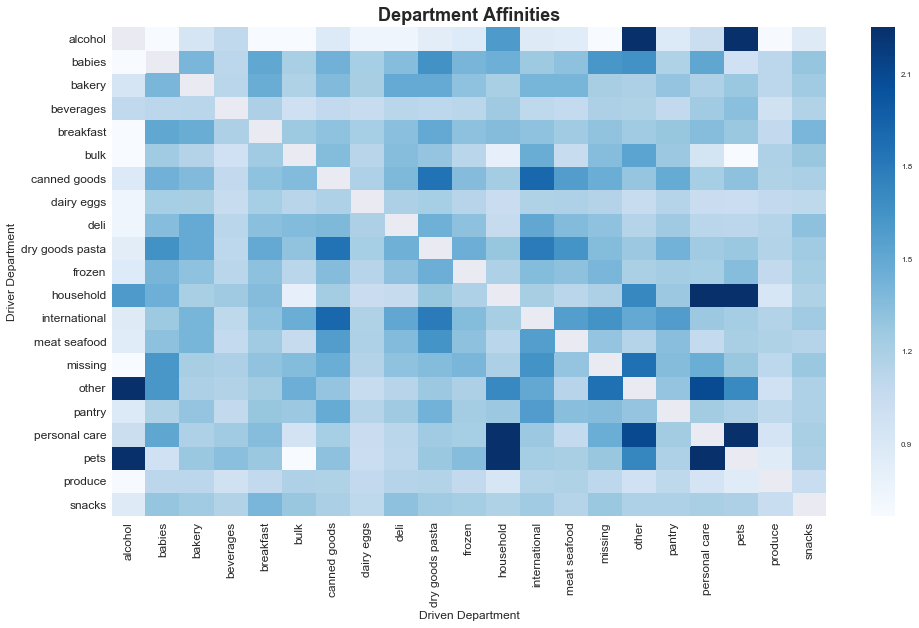

In [119]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.heatmap(dept_affinity_table, robust = True,cmap = 'Blues')

ax.set_title(label='Department Affinities', fontweight='bold', fontsize=18)
ax.set(xlabel='Driven Department' , ylabel='Driver Department')
ax.tick_params(labelsize=12)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('seabornPandas.png', dpi=326)
plt.show()

## Aisle Affinity Analysis

In [31]:
aisle_affinity_list = []
for i in range(100):
    # Select a set of 50000 random orders
    total_orders = 50000
    order_list = pd.DataFrame(random.sample(order.order_id[order.eval_set == 'prior'],total_orders))
    order_list.rename(columns={0:'order_id'},inplace=True)

    ## Read the order products data in chunks for only selected orders
    outResult=[]
    chunksize = 10 ** 6
    for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                             dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
        chunk1 = pd.merge(left = chunk, right = order_list,on = 'order_id', how = 'inner')
        outResult.append(chunk1)

    order_prod_rand = pd.DataFrame(pd.concat(outResult))

    ## Merging product hierarchy to order product
    order_prod_aisle_rand = pd.merge(left = order_prod_rand, right = products, on = 'product_id',how='inner')

    ## Order aisle level data
    order_aisle_rand = order_prod_aisle_rand.groupby(['order_id','aisle_id'])['product_id'].count().reset_index()

    order_aisle_rand = order_aisle_rand.loc[:,['order_id','aisle_id']]

    ## Calculating orders for each aisle
    aisle_ord_count = order_aisle_rand.groupby(['aisle_id']).count().reset_index()

    aisle_ord_count.rename(columns={'order_id':'count_orders'},inplace=True)

    ## Cross joining to get pairs of products in each order
    order_aisle_rand_cross = pd.merge(left = order_aisle_rand, right = order_aisle_rand, on = 'order_id', how= 'inner')

    order_aisle_rand_cross = order_aisle_rand_cross[order_aisle_rand_cross['aisle_id_x']!=order_aisle_rand_cross['aisle_id_y']]

    order_aisle_rand_cross.rename(columns= {'aisle_id_x':"driver_aisle","aisle_id_y":"driven_aisle"},inplace=True)

    aisle_common_orders = order_aisle_rand_cross.groupby(['driver_aisle','driven_aisle']).count().reset_index()

    aisle_common_orders.rename(columns={'order_id':'count_common_orders'},inplace=True)

    ## join the above table to aisle order count to get number of driver and driven orders
    aisle_aff = aisle_common_orders.merge(aisle_ord_count,left_on = 'driver_aisle',right_on = 'aisle_id',how = 'inner')

    aisle_aff.rename(columns={'count_orders':'driver_orders'},inplace=True)

    aisle_aff = aisle_aff.drop('aisle_id',axis = 1)

    aisle_aff = aisle_aff.merge(aisle_ord_count,left_on = 'driven_aisle',right_on = 'aisle_id',how = 'inner')

    aisle_aff.rename(columns={'count_orders':'driven_orders'},inplace=True)
    aisle_aff = aisle_aff.drop('aisle_id',axis = 1)
    
    aisle_aff.sort_values(['driver_aisle','driven_aisle'],ascending=[1,1], inplace=True)
    
    ## Add total orders as 50000
    aisle_aff['Total_orders'] = total_orders
    
    ## Calculate affinity
    aisle_aff['Confidence'] = aisle_aff['count_common_orders'] / aisle_aff['driven_orders']
    aisle_aff['Support'] = aisle_aff['driver_orders'] / aisle_aff['Total_orders']
    aisle_aff['Affinity'] = aisle_aff['Confidence'] / aisle_aff['Support']
    aisle_aff['iteration'] = i
    aisle_affinity_list.append(aisle_aff)

## Remove the combinations with bottom 5% support value in each iteration    
for i in range(100):
    aisle_affinity_list[i] = aisle_affinity_list[i][aisle_affinity_list[i]["Support"] >= \
                                                aisle_affinity_list[i]['Support'].quantile(0.05)]

#### Combining the output of the 100 iterations

In [32]:
## Combine the affinity results from all iterations
aisle_affinity = pd.DataFrame(pd.concat(aisle_affinity_list))

In [33]:
## Calculate the mean and standard deviation of affinities calculated from 100 iterations
aisle_affinity_final = aisle_affinity.groupby(['driver_aisle','driven_aisle']).agg({'Affinity':[np.mean,np.median, np.std]}).reset_index()

In [34]:
aisle_affinity_final.columns = [' '.join(col).strip() for col in aisle_affinity_final.columns.values]

aisle_affinity_final = aisle_affinity_final.merge(aisles,left_on= 'driver_aisle',right_on='aisle_id',how = 'inner')

aisle_affinity_final.rename(columns={'aisle':'driver_name'},inplace=True)
aisle_affinity_final.drop('aisle_id',axis=1,inplace=True)

aisle_affinity_final = aisle_affinity_final.merge(aisles,left_on= 'driven_aisle',right_on='aisle_id',how = 'inner')
aisle_affinity_final.rename(columns={'aisle':'driven_name'},inplace=True)
aisle_affinity_final.drop('aisle_id',axis=1,inplace=True)

aisle_affinity_final.sort_values(['Affinity mean'],ascending=0,inplace=True)

aisle_affinity_table = pd.pivot_table(aisle_affinity_final, values='Affinity mean', index=['driver_name'],
                    columns=['driven_name'], aggfunc=np.sum)

## Top affined aisles

In [94]:
aisle_affinity_final.head(20)

,driver_aisle,driven_aisle,Affinity mean,Affinity median,Affinity std,driver_name,driven_name
7883,28,62,39.234276,38.936612,2.622815,red wines,white wines
3463,62,28,39.234276,38.936612,2.622815,white wines,red wines
17346,62,134,27.372176,27.083553,3.663163,white wines,specialty wines champagnes
7986,134,62,27.206259,26.911139,3.878140,specialty wines champagnes,white wines
17312,28,134,26.482614,26.219686,4.196512,red wines,specialty wines champagnes
3532,134,28,26.421999,26.210862,4.054847,specialty wines champagnes,red wines
3429,27,28,22.698815,22.346396,1.931301,beers coolers,red wines
3299,28,27,22.698815,22.346396,1.931301,red wines,beers coolers
17405,124,134,21.119194,21.045753,3.892659,spirits,specialty wines champagnes
16105,134,124,21.105126,21.037332,3.943748,specialty wines champagnes,spirits


## Plotting the heatmap of aisle affinities

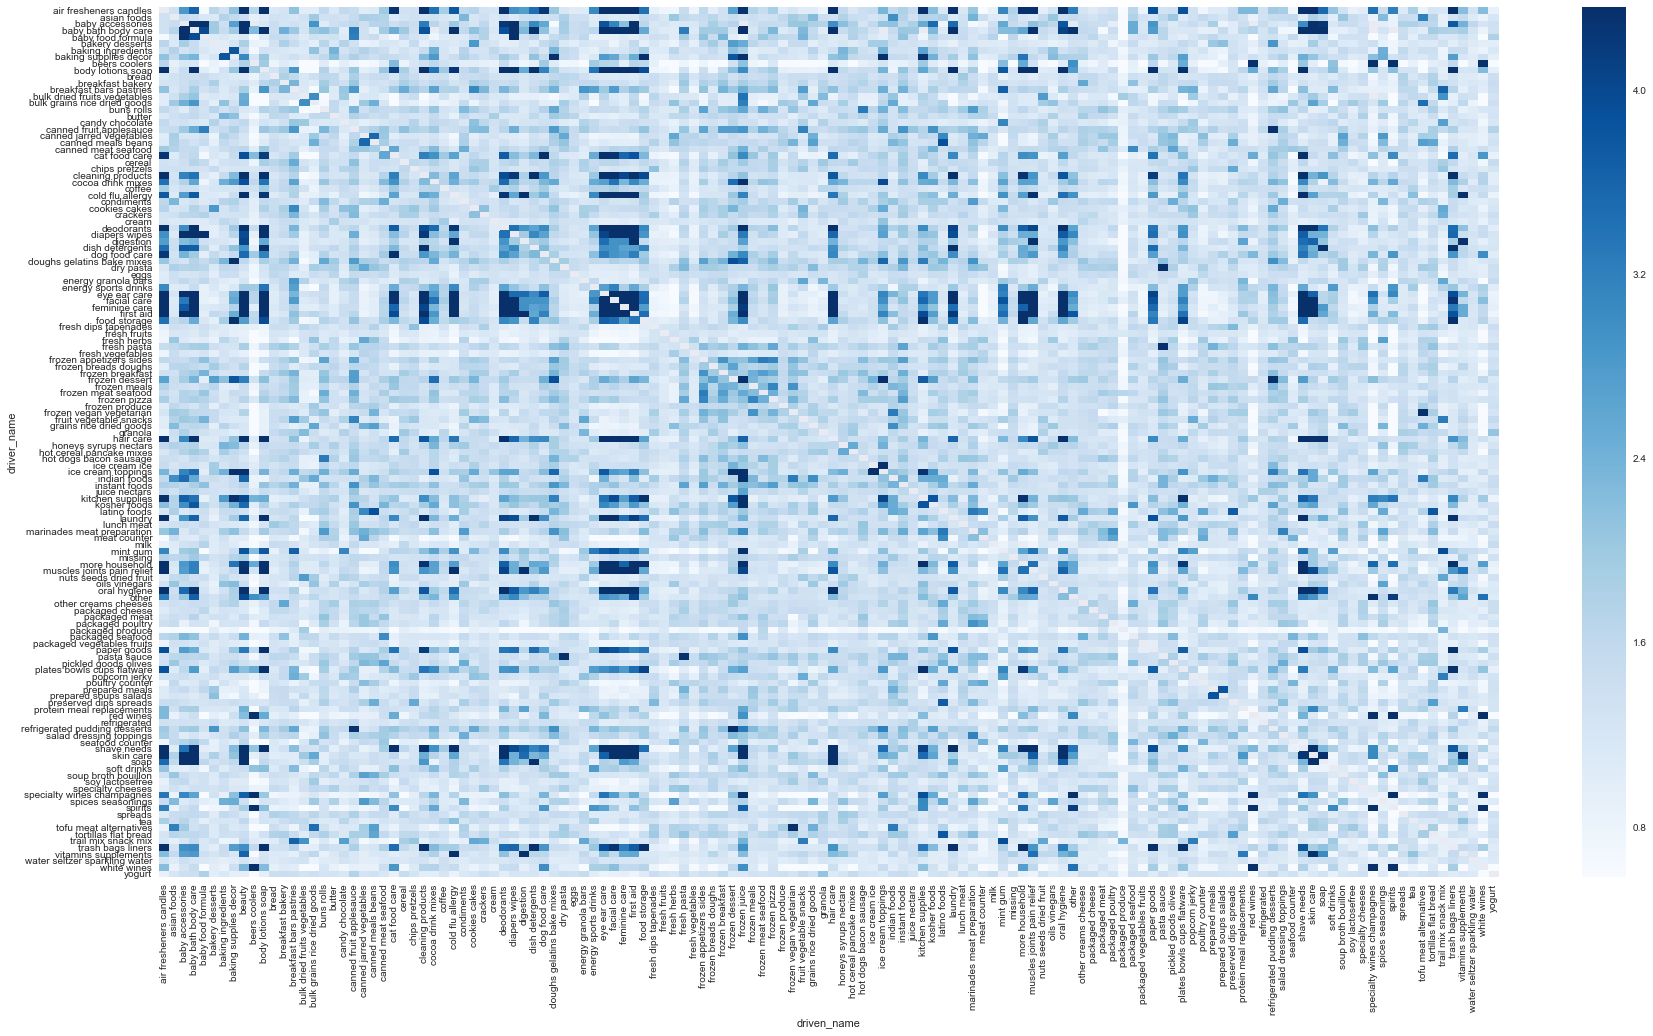

In [101]:
fig, ax = plt.subplots(figsize=(30, 16))
ax = sns.heatmap(aisle_affinity_table, robust = True, cmap = "Blues")

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('seabornPandas1.png', dpi=300)
plt.show()

## Calculating the expected revenue upon using the product recommender system

As we do not have any price data from Instacart, we need to make some assumptions to calculate the expected revenue. 
#### Assumptions:
- The prices of the products are predicted based on a heuristic range of prices taken for each department
- If an order contains a driver department product and does not contain any product from a highly affined driven department, we expect that our recommender system would add a product of the driven department with average price of that department
- Affinity value above 2 is considered high
#### Steps for calculating expected revenue
- We calculate the number of orders containing both the driver and driven departments for highly affined department pairs
- We join a table containing the number of driver department orders
- The difference between the driver department orders and the common orders is the number of orders in which the driver department was bought but not the driven
- We assume that 20% of such orders will have 1 item from driven department if we had a product suggestion
- So we use the average price of the driven department to calculate the expected additional revenue generated by adding a driven department product

In [7]:
product_price = pd.read_csv("products_prices.csv")

In [8]:
order_prior = order[order.eval_set == 'prior']

In [9]:
order_chunks = [order_prior[x:x+50000] for x in xrange(0, len(order_prior), 50000)]

In [10]:
order_dept2_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','department_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.merge(chunk2,on = 'order_id',how = 'inner')
    chunk3 = chunk3[chunk3['department_id_x']!=chunk3['department_id_y']]
    chunk4 = chunk3.groupby(['department_id_x','department_id_y'])['order_id'].count().reset_index()
    order_dept2_all.append(chunk4)

In [68]:
order_dept2_all_1 = pd.DataFrame(pd.concat(order_dept2_all))

order_dept2_all_1 = order_dept2_all_1.groupby(['department_id_x','department_id_y'])['order_id'].sum().reset_index()

In [69]:
order_dept2_all_1.rename(columns = {'department_id_x':'driver_dept','department_id_y':'driven_dept','order_id':'common_orders'},inplace = True)

In [70]:
order_dept2_all_2 = order_dept2_all_1.merge(order_dept_all_1,left_on = 'driver_dept',right_on = 'department_id',how='inner')

In [71]:
order_dept2_all_2.drop(['department_id','dept_penetration'],axis =1,inplace=True)

In [72]:
order_dept2_all_2.rename(columns = {"department":"driver_name",'no_of_orders':'driver_orders'},inplace=True)

In [73]:
expected_dept = order_dept2_all_2.merge(dept_affinity_final.drop(['Affinity median','Affinity std','driver_name'],axis =1), on=['driver_dept','driven_dept'],)

In [74]:
expected_dept = expected_dept[expected_dept['Affinity mean']>=2]

In [75]:
expected_dept['expected_inc_orders'] = (expected_dept['driver_orders'] - expected_dept['common_orders']) / 5

In [76]:
departmen_mean_price = product_price.groupby(['department_id'])['Price'].mean().reset_index()

In [79]:
expected_dept = expected_dept.merge(departmen_mean_price,left_on= 'driven_dept',right_on = 'department_id',how='inner')

In [80]:
expected_dept['Expected_revenue_Inc'] = expected_dept['expected_inc_orders']*expected_dept['Price']

In [86]:
expected_revenue_increase = expected_dept.Expected_revenue_Inc.sum()

## Calculating current total revenue

In [85]:
current_revenue = 0
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = product_price, on = 'product_id', how = 'inner')
    current_revenue += chunk1.Price.sum()

## Calculating expected % increse in revenue due to product recommendations

In [87]:
percent_inc = expected_revenue_increase/current_revenue

In [89]:
current_revenue

1949585712L

In [90]:
expected_revenue_increase

24909578.92922098

In [88]:
percent_inc

0.012776857552811702

#### By conseravtive estimates we can expect aprrox. 25 million USD increase in revenue if we implement a product reccommandation sysytem